# Лекция 3: PyTorch - построение моделей

__Автор: Сергей Вячеславович Макрушин__ e-mail: SVMakrushin@fa.ru 

Финансовый универсиет, 2021 г. 

При подготовке лекции использованы материалы:
* ...

v 0.13

In [516]:
# загружаем стиль для оформления презентации
from IPython.display import HTML
from urllib.request import urlopen
html = urlopen("file:./lec_v1.css")
HTML(html.read().decode('utf-8'))

---
## Импорты

* Нужно установить PyTorch (см предыдущую лекцию!)

In [517]:
import math
import csv
import itertools as it
from collections import Counter
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets

#---------
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms
from torchvision.transforms.functional import normalize
import torchvision.datasets as dset

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler, Sampler

## Разделы: <a class="anchor" id="разделы"></a>
* [Загрузка и преобразование данных](#загрузка)
* [Тензоры и опреации с ними в PyTorch](#тензоры)
    * [Создание тензоров](#создание-тензоров)
    * [Операции с тензорами](#операции-тензоры)    
        * [Арифметические операции и математические функции:](#aрифметические)        
        * [Операции, изменяющие размер тензора](#размер)        
        * [Операции агрегации](#агрегации)        
        * [Матричные операции](#aрифметические)                
-

* [к оглавлению](#разделы)

-----

## Загрузка и преобразование данных <a class="anchor" id="установка"></a>
* [к оглавлению](#разделы)

Принципиальная логика организации работы с данными в PyTorch:
1. Создается объект `Dataset`
    * `Dataset` обеспечивает доступ данным (с помощью интерфеса )
    * в параметр `transform` конструктора `Dataset` передается вызываемый объкт, обеспечивающий трансформацию исходных данных 
2. `Dataset` передается в `DataLoader`
    * `DataLoader` обеспечивает загрузку данных батчами, распараллеливает загрузку данных и т.п.
    
см.: 
* общая логика: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
* трансформеры: https://pytorch.org/docs/stable/torchvision/transforms.html
* DataLoader и то что его окружает: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

__Dataset Types__

The most important argument of DataLoader constructor is __dataset__, which indicates a dataset object to load data from. PyTorch supports two different types of datasets:
* map-style datasets
    * the `__getitem__()` and `__len__()` protocols, and represents a map from (possibly non-integral) indices/keys to data samples.
    * For example, such a dataset, when accessed with `dataset[idx]`, could read the `idx`-th image and its corresponding label from a folder on the disk.
    * Note: `DataLoader` __by default constructs a index sampler that yields integral indices__. To make it work with a map-style dataset with non-integral indices/keys, a custom sampler must be provided.
* iterable-style datasets.
    * IterableDataset implements the `__iter__()` protocol, and represents an iterable over data samples. This type of datasets is particularly suitable for cases __where random reads are expensive or even improbable__, and where the batch size depends on the fetched data.

* see: https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset

from sklearn import datasets
raw_data = datasets.load_wine()
raw_data

Информация о датасете WINE: https://archive.ics.uci.edu/ml/datasets/wine

In [518]:
from sklearn import datasets
raw_data = datasets.load_wine()
raw_data.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [520]:
print(raw_data['feature_names'])
print(raw_data['data'][:3])
print('Values: ', Counter(raw_data['target']))

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
[[1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
  2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03]
 [1.320e+01 1.780e+00 2.140e+00 1.120e+01 1.000e+02 2.650e+00 2.760e+00
  2.600e-01 1.280e+00 4.380e+00 1.050e+00 3.400e+00 1.050e+03]
 [1.316e+01 2.360e+00 2.670e+00 1.860e+01 1.010e+02 2.800e+00 3.240e+00
  3.000e-01 2.810e+00 5.680e+00 1.030e+00 3.170e+00 1.185e+03]]
Values:  Counter({1: 71, 0: 59, 2: 48})


In [521]:
with open('./data/wine/wine.csv') as wine_csv:
    # load data:
    wine_data = list(csv.reader(wine_csv, delimiter=','))

wine_data_it = iter(wine_data)
print('Header', list(next(wine_data_it)))
for line_n, line in enumerate(it.islice(wine_data_it, 3)):
    print(f'line: {line_n} | {line}')
    
print('Values: ', Counter([l[0] for l in wine_data[1:]]))

Header ['Wine', 'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 'Hue', 'OD', 'Proline']
line: 0 | ['1', '14.23', '1.71', '2.43', '15.6', '127', '2.8', '3.06', '.28', '2.29', '5.64', '1.04', '3.92', '1065']
line: 1 | ['1', '13.2', '1.78', '2.14', '11.2', '100', '2.65', '2.76', '.26', '1.28', '4.38', '1.05', '3.4', '1050']
line: 2 | ['1', '13.16', '2.36', '2.67', '18.6', '101', '2.8', '3.24', '.3', '2.81', '5.68', '1.03', '3.17', '1185']
Values:  Counter({'2': 71, '1': 59, '3': 48})


In [522]:
# Implement a custom Dataset:
# inherit Dataset
# implement __init__ , __getitem__ , and __len__  
class WineDataset(Dataset):

    def __init__(self, transform=None, verbose=False):
        # load dataset from CSV file (first row: labels)
        xy = np.loadtxt('./data/wine/wine.csv', delimiter=',', dtype=np.float32, skiprows=1)

        # note that we do not convert to tensor here
        self.n_samples = xy.shape[0] # number of samples        
        self.y_data = xy[:, [0]] # y in first column (shape: N*1)       
        self.x_data = xy[:, 1:]
        if verbose:
            print(f'y shape:{self.y_data.shape()}')
            print(f'x shape:{self.x_data.shape()}')            

        # save transformer
        self.transform = transform

    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]

        # apply transformer:
        if self.transform:
            sample = self.transform(sample)

        return sample

    def __len__(self):
        return self.n_samples

In [523]:
print('Without Transformation:')
dataset = WineDataset()

X, y = dataset[0]
print('X:', X, type(X), X.shape)
print('y:', y, type(y), y.shape)

Without Transformation:
X: [1.423e+01 1.710e+00 2.430e+00 1.560e+01 1.270e+02 2.800e+00 3.060e+00
 2.800e-01 2.290e+00 5.640e+00 1.040e+00 3.920e+00 1.065e+03] <class 'numpy.ndarray'> (13,)
y: [1.] <class 'numpy.ndarray'> (1,)


__Transforms__

Часто необходим некоторый препроцессинг данных получаемых из данных, оформленных в виде `Dataset`.

Мы будем реализовывать препроцессинг в виде __callable classes__ вместо обычных функций, это позволит не передавать параметры трансформации при каждом вызове преобразований. Для создания вызываемых классов в них необходимо реализовать функцию вызова `__call__` и, если необходимо, конструктор `__init__`, через который можно передавать параметры трансформациия:

```python
tsfm = Transform(params)
transformed_sample = tsfm(sample)
```

* В `torchvision.transforms` находится много готовых трансформеров (см.  https://pytorch.org/docs/stable/torchvision/transforms.html ), большая часть ориентирована на преобразование изображений, но есть несколько универсальных инструментов:
    * `torchvision.transforms.Compose` - позволяет создать трансформер из нескольких трансформеров, применяемых последовательно. Пример:
    
```python
transforms.Compose([
    transforms.CenterCrop(10),
    transforms.ToTensor()
])
```

In [524]:
# Custom Transforms
# implement __call__(self, sample)
class ToTensor:
    # Convert ndarrays to Tensors
    def __call__(self, sample):
        inputs, targets = sample
        return torch.from_numpy(inputs), torch.from_numpy(targets)

In [525]:
print('With Tensor Transform')
dataset = WineDataset(transform=ToTensor())

X, y = dataset[0]
print('X:', X, type(X), X.size())
print('y:', y, type(y), y.size())

With Tensor Transform
X: tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) <class 'torch.Tensor'> torch.Size([13])
y: tensor([1.]) <class 'torch.Tensor'> torch.Size([1])


In [526]:
class MulTransform:
    # multiply inputs with a given factor
    def __init__(self, factor):
        self.factor = factor

    # multiply imputs by factor:
    def __call__(self, sample):
        inputs, targets = sample
        inputs *= self.factor
        return inputs, targets

In [527]:
print('With Tensor and Multiplication Transform')
# create composed transformer:
composed_tfms = torchvision.transforms.Compose([ToTensor(), MulTransform(4)])
dataset_mul = WineDataset(transform=composed_tfms)

X, y = dataset_mul[0]
print('X:', X, type(X), X.size())
print('y:', y, type(y), y.size())

With Tensor and Multiplication Transform
X: tensor([5.6920e+01, 6.8400e+00, 9.7200e+00, 6.2400e+01, 5.0800e+02, 1.1200e+01,
        1.2240e+01, 1.1200e+00, 9.1600e+00, 2.2560e+01, 4.1600e+00, 1.5680e+01,
        4.2600e+03]) <class 'torch.Tensor'> torch.Size([13])
y: tensor([1.]) <class 'torch.Tensor'> torch.Size([1])


Имеется модуль `torchvision.transforms.functional` (обычно импортируется как `python import torch.nn.functional as F`) в котором есть множество готовых трансформеров (в основном для преобразования изображений):
* подробнее см.: https://pytorch.org/docs/stable/torchvision/transforms.html 

```python
class Normalize(object):
    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.

        Returns:
            Tensor: Normalized Tensor image.
        """
        return F.normalize(tensor, self.mean, self.std, self.inplace)

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
```

__DataLoader__

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи. 
Он дает возможность указать `Sampler`, который выбирает, какие примеры из датасета использовать для тренировки. Этот параметр можно использовать для разделения данных на training и validation.

`torch.utils.data.DataLoader` это итератор, который обеспечивает:
* организацию данных в батчи (batching the data)
* перемешивание данных (shuffling the data)
* параллельную загрузку данных с использованием multiprocessing workers.

Основные параметры:
* `dataset` (Dataset) – dataset from which to load the data.
* `batch_size` (int, optional) – how many samples per batch to load (default: 1).
* `shuffle` (bool, optional) – set to True to have the data reshuffled at every epoch (default: False).
* `sampler` (Sampler, optional) – defines the strategy to draw samples from the dataset. If specified, shuffle must be False.
* `num_workers` (int, optional) – how many subprocesses to use for data loading. 0 means that the data will be loaded in the main process. (default: 0)

Подробнее см. в: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

In [63]:
# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=0)

In [528]:
dataiter = iter(train_loader)
data = dataiter.next()
features, labels = data
print('features:', features, features.shape)
print('labels:', labels, labels.shape)      

features: tensor([[3.4839e+06, 5.1642e+05, 7.0255e+05, 4.4040e+06, 2.6739e+07, 7.8643e+05,
         8.4673e+05, 8.1265e+04, 4.3516e+05, 1.5729e+06, 2.8049e+05, 7.4449e+05,
         3.3292e+08],
        [1.4879e+07, 1.6672e+06, 2.6005e+06, 1.7302e+07, 1.1325e+08, 3.4603e+06,
         4.1209e+06, 3.3554e+05, 1.9504e+06, 9.1226e+06, 1.2897e+06, 2.9570e+06,
         1.7616e+09],
        [3.3345e+06, 4.5875e+05, 5.9769e+05, 5.8982e+06, 2.2020e+07, 3.6176e+05,
         4.6137e+05, 1.2583e+05, 4.2729e+05, 8.6508e+05, 2.3069e+05, 6.3439e+05,
         1.2793e+08],
        [3.1457e+06, 3.9584e+05, 6.3439e+05, 5.7672e+06, 2.2544e+07, 3.8011e+05,
         3.2768e+05, 1.3107e+05, 4.2729e+05, 9.4372e+05, 2.7525e+05, 6.9468e+05,
         1.1796e+08]]) torch.Size([4, 13])
labels: tensor([[1.],
        [1.],
        [2.],
        [2.]]) torch.Size([4, 1])


In [529]:
# Dummy Training loop
num_epochs = 2
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):        
        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')

178 45
Epoch: 1/2, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 20/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 25/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 30/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 35/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 40/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/2, Step 45/45| Inputs torch.Size([2, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 2/2, Step 20/45| Inputs torch.Size([4, 1

In [1]:
ls

 ’®¬ ў гбва®©бвўҐ E Ё¬ҐҐв ¬ҐвЄг Data
 ‘ҐаЁ©­л© ­®¬Ґа в®¬ : EE2C-D1DD

 ‘®¤Ґа¦Ё¬®Ґ Ї ЇЄЁ E:\YandexDisk\Python\Ipynb\ML_DL_2021\lec03_PyTorch_p3

08.03.2021  23:04    <DIR>          .
08.03.2021  23:04    <DIR>          ..
04.02.2021  16:08    <DIR>          .ipynb_checkpoints
08.03.2021  23:04           199я469 TCN20_lNNp3_v12.ipynb
               1 д ©«®ў        199я469 Ў ©в
               3 Ї Ї®Є  336я128я081я920 Ў ©в бў®Ў®¤­®


---
## Нормализация

<center>     
    <img src="./img03/preprocessing_2.png" alt="Предобработка данных" style="width: 400px;"/>
    <strong>Предобработка данных</strong>
</center>


In [530]:
bs = 4

composed_tfms = transforms.Compose([
            ToTensor() 
            # don't use Normalize() for the first time
        ])

dataset = WineDataset(transform=composed_tfms)

In [133]:
# axes.ndim

2

In [531]:
# axes.shape

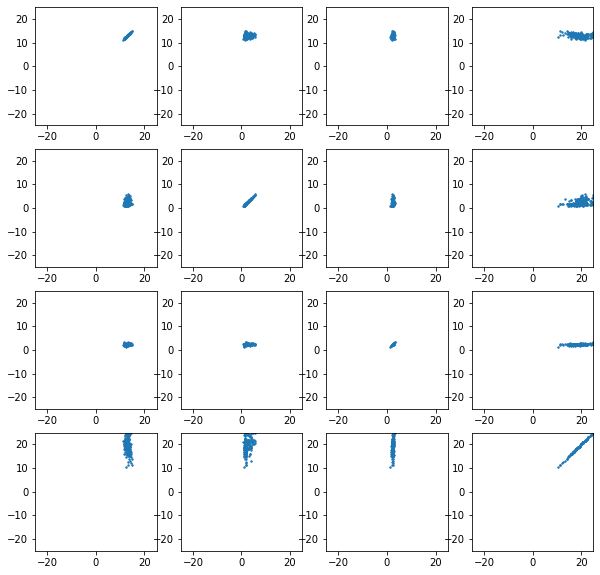

In [184]:
points = dataset.x_data
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
use_lim = True
lim = 25.0

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):      
        ax = axes[i, j]
        if use_lim:
            ax.set_xlim([-lim, lim])                
            ax.set_ylim([-lim, lim])
        ax.scatter(points[:, j], points[:, i], s = 2)

In [532]:
# получаем среднее по всему датасету:
wine_mean = dataset.x_data.mean(axis=0)
wine_mean

array([1.3000614e+01, 2.3363481e+00, 2.3665185e+00, 1.9494946e+01,
       9.9741570e+01, 2.2951121e+00, 2.0292699e+00, 3.6185396e-01,
       1.5908992e+00, 5.0580897e+00, 9.5744956e-01, 2.6116843e+00,
       7.4689325e+02], dtype=float32)

In [533]:
# получаем стандартное отклонение по всему датасету:
wine_std = dataset.x_data.std(axis=0)
wine_std

array([8.0954307e-01, 1.1140037e+00, 2.7357230e-01, 3.3301697e+00,
       1.4242310e+01, 6.2409055e-01, 9.9604911e-01, 1.2410324e-01,
       5.7074893e-01, 2.3117647e+00, 2.2792861e-01, 7.0799321e-01,
       3.1402167e+02], dtype=float32)

In [515]:
# Тест для фичи 0:

# r = (dataset.x_data - wine_mean)/wine_std
# r[:, 0]

In [534]:
class Normalize:
    def __init__(self, mean, std, inplace=False):
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)
        self.inplace = inplace

    def __call__(self, sample):
        inputs, targets = sample
        
        if not self.inplace:
            inputs = inputs.clone()
        inputs.sub_(self.mean).div_(self.std)
        return inputs, targets

In [535]:
batch_size = 4

composed_tfms = transforms.Compose([
            ToTensor(), 
            Normalize(wine_mean, wine_std)
        ])

train_ds = WineDataset(transform=composed_tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False)

In [536]:
dataiter = iter(train_dl)
data = dataiter.next()
features, labels = data
print('features:', features, features.shape)
print('labels:', labels, labels.shape)   

features: tensor([[ 1.5186, -0.5622,  0.2320, -1.1696,  1.9139,  0.8090,  1.0348, -0.6596,
          1.2249,  0.2517,  0.3622,  1.8479,  1.0130],
        [ 0.2463, -0.4994, -0.8280, -2.4908,  0.0181,  0.5686,  0.7336, -0.8207,
         -0.5447, -0.2933,  0.4060,  1.1135,  0.9652],
        [ 0.1969,  0.0212,  1.1093, -0.2687,  0.0884,  0.8090,  1.2155, -0.4984,
          2.1360,  0.2690,  0.3183,  0.7886,  1.3951],
        [ 1.6916, -0.3468,  0.4879, -0.8093,  0.9309,  2.4914,  1.4665, -0.9819,
          1.0322,  1.1861, -0.4275,  1.1841,  2.3346]]) torch.Size([4, 13])
labels: tensor([[1.],
        [1.],
        [1.],
        [1.]]) torch.Size([4, 1])


In [537]:
# Dummy Training loop
num_epochs = 1
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/4)
print(total_samples, n_iterations)


inputs_points = None
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):        
        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process
        if inputs_points is None:
            inputs_points = inputs.clone()
        else:
            inputs_points = torch.cat((inputs_points, inputs))
        
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')

178 45
Epoch: 1/1, Step 5/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 10/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 15/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 20/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 25/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 30/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 35/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 40/45| Inputs torch.Size([4, 13]) | Labels torch.Size([4, 1])
Epoch: 1/1, Step 45/45| Inputs torch.Size([2, 13]) | Labels torch.Size([4, 1])


In [538]:
inputs_points.size()

torch.Size([178, 13])

In [181]:
# Тест для фичи 0:

# inputs_points[:, 0]

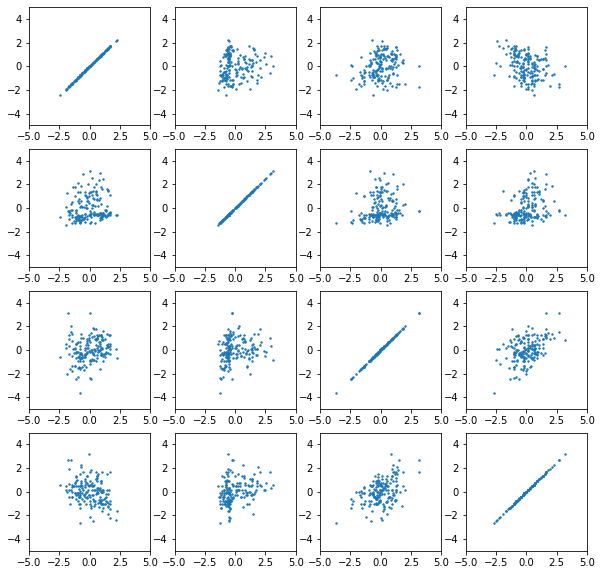

In [539]:
points = inputs_points
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
use_lim = True
lim = 5.0

for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):      
        ax = axes[i, j]
        if use_lim:
            ax.set_xlim([-lim, lim])                
            ax.set_ylim([-lim, lim])
        ax.scatter(points[:, j], points[:, i], s = 2)

In [ ]:
mean, std = np.mean(image), np.std(image)
image = image - mean
image = image / std

In [90]:
dataset.x_data

array([[1.423e+01, 1.710e+00, 2.430e+00, ..., 1.040e+00, 3.920e+00,
        1.065e+03],
       [1.320e+01, 1.780e+00, 2.140e+00, ..., 1.050e+00, 3.400e+00,
        1.050e+03],
       [1.316e+01, 2.360e+00, 2.670e+00, ..., 1.030e+00, 3.170e+00,
        1.185e+03],
       ...,
       [1.327e+01, 4.280e+00, 2.260e+00, ..., 5.900e-01, 1.560e+00,
        8.350e+02],
       [1.317e+01, 2.590e+00, 2.370e+00, ..., 6.000e-01, 1.620e+00,
        8.400e+02],
       [1.413e+01, 4.100e+00, 2.740e+00, ..., 6.100e-01, 1.600e+00,
        5.600e+02]], dtype=float32)

__Batch normalization__ 

$$x^{(k)}=\frac{x^{(k)}-\mathbb{E} \left [x^{(k)}\right ]}{\sqrt{\operatorname{Var}\left [x^{(k)}\right ]}}$$

$$y^{(k)} =\gamma^{k}x^{(k)}+\beta^{k}$$

* Ускоряет и стаблизирует тренировку
* Регуляризует
* Не так важна инициализация

<center>     
    <img src="./img03/prec_rec_1.png" alt="Предобработка данных" style="width: 250px;"/>
    <strong>Предобработка данных</strong>
</center>

* Правильные ответы:
    * TP - истино-положительное решение
    * TN - истино-отрицательное решение
* Ошибки:
    * FP - ложно-положительное решение (false positive) / ошибка 1го рода
    * FN - ложно-отрицательное решение (false negative) / ошибка 2го рода


* Тривиальная метрика качества в двухклассовой классификации: $Accuracy=\frac{correct}{total}$.
    * Проблема: при несбалансированном наборе данных (обычно он всегда такой!) тривиальный ответ может давать высокую Accuracy.
* Улучшенные метрики качества:
    * $Precision=\frac{TP}{TP+FP}$ - точность 
    * $Recall=\frac{TP}{TP+FN}$ - полнота


* $F_1=2\cdot\frac{Precision \cdot Recall}{Precision+Recall}$ (в диапазоне от 0 до 1).

* The general formula for positive real $\beta$, where $\beta$ is chosen such that recall is considered $\beta$ times as important as precision, is: $F_\beta = (1 + \beta^2) \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{(\beta^2 \cdot \mathrm{precision}) + \mathrm{recall}}$


__Перекрестная энтропия__

В задаче классификации мы хотим оценить вероятность различных исходов. Если ожидаемая вероятность исхода $i$ это $q_i$ при том что частота (эмпирическая оценка вероятности) исхода $i$ в тренировочном множестве это $p_i$ и всего в тренировочном множестве имеется $N$ исходов тогда правдоподобие в тренировочном множестве пропорционально:

$$\prod_i q_i^{N \cdot p_i}$$

тогда логарифм правдоподобия (log-likelihood) деленный на $N$ это:

$$\frac{1}{N} \log \prod_i q_i^{N p_i} = \sum_i p_i \log q_i = -H(p, q)$$

таким образом максимизация правдоподобия происходит при минимизации функции перекрестной энтропии (cross entropy), определяемой для дискретных случайных величин $p$ и $q$ по формуле:

$$H(p,q) = -\sum_{x\in\mathcal{X}} p(x)\, \log q(x)$$


Т.к. в реализации задач оптимизации принято искать параметры модели, при которых достигается минимум (в нашем случае - минимум функции потерь), то обычно минимзируют функцию потерь Negative Log-likelihood:

$$\mathcal{L} = - \sum_i p_i \log q_i = H(p, q)$$

__Логистическая регрессия__

* Рассмотрим случай __логистической регресии__ которая используется для классификации наблюдений на два класса, обозначим их $0$ и $1$.
* Результат модели для наблюдения, представленного вектором факторов (features) $\mathbf{x}$, может быть интерпретирован как вероятность отнесения наблюдения к одному из классов. Для этого используется  __логистическая функция__: $\sigma(z)=1/(1+e^{-z})$. 

<center>     
    <img src="./img03/1920px-Logistic-curve.svg.png" alt="Предобработка данных" style="width: 250px;"/>
    <strong>Предобработка данных</strong>
</center>


При этом $z$ это результат преобразования входного вектора $\mathbf{x}$, чаще всего реализуемого с помощью линейной функции: $z = \mathbf{w}\cdot\mathbf{x}$.
* Тогда:
    * веротяноть значения $y=1$ для наблюдения $\mathbf{x}$:
$$q_{y=1}\ =\ \hat{y}\ \equiv\ \sigma (\mathbf{w}\cdot\mathbf{x})\ = 1/(1+e^{-\mathbf{w}\cdot\mathbf{x}})$$
    * и, соответственно, вероятность значения $y=0$:
$$q_{y=0}\ =\ 1-\hat{y}$$

* <em class="ex"></em> Например, мы имеем $N$ наблюдений имеющих индексы $n=1,\dots,N$ и линейную функцию преобразования входного вектора, тогда среднее значение функции потерь:

$$\begin{align}
    \mathcal{L}(\mathbf{w})\ &=\ \frac1N\sum_{n=1}^N H(p_n,q_n)\ =\ -\frac1N\sum_{n=1}^N\ \bigg[y_n  \log \hat y_n + (1 - y_n)  \log (1 - \hat y_n)\bigg]\,,
\end{align}$$

где при использовании ленейной функции преобразования имеем $\hat{y}_n = \sigma(z) = \sigma(\mathbf{w}\cdot\mathbf{x}_n) = 1/(1+e^{-\mathbf{w}\cdot\mathbf{x}_n})$

In [185]:
wine_mean, wine_std

(array([1.3000614e+01, 2.3363481e+00, 2.3665185e+00, 1.9494946e+01,
        9.9741570e+01, 2.2951121e+00, 2.0292699e+00, 3.6185396e-01,
        1.5908992e+00, 5.0580897e+00, 9.5744956e-01, 2.6116843e+00,
        7.4689325e+02], dtype=float32),
 array([8.0954307e-01, 1.1140037e+00, 2.7357230e-01, 3.3301697e+00,
        1.4242310e+01, 6.2409055e-01, 9.9604911e-01, 1.2410324e-01,
        5.7074893e-01, 2.3117647e+00, 2.2792861e-01, 7.0799321e-01,
        3.1402167e+02], dtype=float32))

In [220]:
torch.cuda.is_available()

False

__Решаем задачу двухклассовой классификации__

Используем:
* результат $z$ преобразования входного вектора $\mathbf{x}$, (чаще всего реализуемого с помощью линейной функции: $z = \mathbf{w}\cdot\mathbf{x}$) направляем на сигмоиду: https://pytorch.org/docs/master/generated/torch.nn.Sigmoid.html
* В качестве функции ошибки используем Binary Cross Entropy: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss , используем усреднение по мини батчу (значение по умолчанию для параметра reduction = 'mean').

In [540]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# parameters:
positive_class_label = 3.0

# Hyper-parameters #1
batch_size = 20
shuffle_dataset = True

class TwoClass:
    def __init__(self, positive_label, inplace=False):
        self.positive_label = positive_label

    def __call__(self, sample):                
        inputs, targets = sample
        targets_tc = torch.empty(targets.size())
        targets_tc[targets == self.positive_label] = 1.0
        targets_tc[targets != self.positive_label] = 0.0   
#         print(inputs, targets_tc)
        return inputs, targets_tc


composed_tfms = transforms.Compose([
            ToTensor(), 
            Normalize(wine_mean, wine_std),
            TwoClass(positive_label=positive_class_label)
        ])

train_ds = WineDataset(transform=composed_tfms)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle_dataset)


# Get features size:
dataiter = iter(train_dl)
data = dataiter.next()
# print(f'data: {data}')
# features, labels = data
inputs, targets = data

# Hyper-parameters #2
input_size = inputs.shape[1] # use features size
hidden_size = 50
num_classes = 2
print(f'input_size:{input_size}, hidden_size:{hidden_size}, num_classes:{num_classes}')

num_epochs = 30
learning_rate = 0.001


# print('inputs:', inputs, features.shape)
# print('targets:', targets, targets.shape)
# ----------

# Fully connected neural network with one hidden layer
class NNTwoClases(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NNTwoClases, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, 1) # класса 2 вероятность y^ - одна  
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.sigmoid(out)
        return out

model = NNTwoClases(input_size, hidden_size).to(device)

# Loss and optimizer
# see: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (inputs, targets_) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets_ = targets_.to(device)
        
        # Forward pass
        outputs = model(inputs)
#         print(outputs, targets_)
        loss = criterion(outputs, targets_)
        
        # zero grad before new step        
        optimizer.zero_grad()                
        # Backward and optimize        
        loss.backward()
        optimizer.step()
                
        if (i+1) % 2 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')                            

input_size:13, hidden_size:50, num_classes:2
Epoch [1/30], Step [2/45], Loss: 0.6712
Epoch [1/30], Step [4/45], Loss: 0.7114
Epoch [1/30], Step [6/45], Loss: 0.6287
Epoch [1/30], Step [8/45], Loss: 0.6647
Epoch [2/30], Step [2/45], Loss: 0.6107
Epoch [2/30], Step [4/45], Loss: 0.6127
Epoch [2/30], Step [6/45], Loss: 0.5520
Epoch [2/30], Step [8/45], Loss: 0.6235
Epoch [3/30], Step [2/45], Loss: 0.5520
Epoch [3/30], Step [4/45], Loss: 0.5280
Epoch [3/30], Step [6/45], Loss: 0.5445
Epoch [3/30], Step [8/45], Loss: 0.5441
Epoch [4/30], Step [2/45], Loss: 0.4312
Epoch [4/30], Step [4/45], Loss: 0.4813
Epoch [4/30], Step [6/45], Loss: 0.5055
Epoch [4/30], Step [8/45], Loss: 0.4973
Epoch [5/30], Step [2/45], Loss: 0.4854
Epoch [5/30], Step [4/45], Loss: 0.4158
Epoch [5/30], Step [6/45], Loss: 0.3917
Epoch [5/30], Step [8/45], Loss: 0.4909
Epoch [6/30], Step [2/45], Loss: 0.4005
Epoch [6/30], Step [4/45], Loss: 0.4004
Epoch [6/30], Step [6/45], Loss: 0.3797
Epoch [6/30], Step [8/45], Loss: 0.

__Добавляем train/test split__:

Разделим данные на training и test с использованием классов `SubsetRandomSampler` и `DataLoader`.

`DataLoader` подгружает данные, предоставляемые классом `Dataset`, во время тренировки и группирует их в батчи.
Он дает возможность указать `Sampler` (в нашем случае `SubsetRandomSampler`), который выбирает, какие примеры из датасета использовать для тренировки. Мы используем это, чтобы разделить данные на training и test.

Подробнее: https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [227]:
# dataset = list(range(178))
# validation_split = .2
# random_seed= 42
# shuffle_dataset = True

# dataset_size = len(dataset)
# indices = list(range(dataset_size))
# split = int(np.floor(validation_split * dataset_size))
# if shuffle_dataset :
#     np.random.seed(random_seed)
#     np.random.shuffle(indices)
# train_indices, val_indices = indices[split:], indices[:split]

# # train_indices, val_indices

In [548]:
#LOAD DATA

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# parameters:
positive_class_label = 3.0

# Hyper-parameters #1
batch_size = 20
test_split = .2
random_seed= 42
shuffle_dataset = True

composed_tfms = transforms.Compose([
            ToTensor(), 
            Normalize(wine_mean, wine_std),
            TwoClass(positive_label=positive_class_label)
        ])

dataset = WineDataset(transform=composed_tfms)

# Creating data indices for training and test splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)

# Get inputs(features) size:
dataiter = iter(train_dl)
data = dataiter.next()
# features, labels = data
inputs, targets = data
# print(f'inputs: {inputs.shape}, {inputs}, targets: {targets.shape}, {targets}')

# parameters:
dataset_num_classes = 2
dataset_input_size = inputs.shape[1]

In [549]:
# len(train_indices), len(test_indices)

In [558]:
# DEFINE MODEL

# Hyper-parameters #2
input_size = dataset_input_size # use inputs size
hidden_size = 50 # 20 | 50
num_classes = dataset_num_classes # 2
print(f'input_size:{input_size}, hidden_size:{hidden_size}, num_classes:{num_classes}')

num_epochs = 60
learning_rate = 0.001

# Fully connected neural network with one hidden layer
class NNTwoClases(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NNTwoClases, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() # on|off
        self.l2 = nn.Linear(hidden_size, 1) # класса 2 вероятность y^ - одна  
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out) # on|off
        out = self.l2(out)
        out = self.sigmoid(out)
        return out

model = NNTwoClases(input_size, hidden_size).to(device)

# Loss and optimizer
# see: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

input_size:13, hidden_size:50, num_classes:2


In [559]:
# TRAINING THE NETWORK
def train(model, device, train_dl, optimizer):
    #set model in train() mode:
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets) 
        
        # Backward and optimize        
        # zero grad before new step        
        optimizer.zero_grad()                        
        loss.backward()
        optimizer.step()   

        # calculating the total_loss for checking
        total_loss += loss           
        
        # PREDICTIONS 
        total_samples += targets.shape[0]    
        predictions = outputs.round()
        correct_samples += torch.sum(predictions==targets)
#         if i ==0:
#             print(f'outputs: {outputs}, predictions:{predictions}, targets:{targets}, correct_samples:{correct_samples}')        
        
    train_accuracy = float(correct_samples) / total_samples        
    
    return total_loss, train_accuracy                                  

In [560]:
# TESTING THE MODEL
def test(model, device, test_dl):
    #set model in eval() mode (it skips Dropout etc):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0 
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_dl):
            #LOAD THE DATA IN A BATCH            
            inputs, targets = inputs.to(device), targets.to(device)            
                       
            # apply model to input data
            outputs = model(inputs)        
                       
            #PREDICTIONS
            total_samples += targets.shape[0]    
            predictions = outputs.round()
            correct_samples += torch.sum(predictions==targets)        
        
    test_accuracy = correct_samples / total_samples        
    
    return test_accuracy              

In [561]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer)
    test_accuracy = test(model, device, test_dl)
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

Epoch [1/60], Loss: 5.3182, Train acc: 0.6503, Test acc: 0.7143
Epoch [2/60], Loss: 4.7288, Train acc: 0.7762, Test acc: 0.7429
Epoch [3/60], Loss: 4.4194, Train acc: 0.8182, Test acc: 0.7714
Epoch [4/60], Loss: 4.0325, Train acc: 0.8601, Test acc: 0.8286
Epoch [5/60], Loss: 3.6260, Train acc: 0.8881, Test acc: 0.9143
Epoch [6/60], Loss: 3.6172, Train acc: 0.9021, Test acc: 0.9429
Epoch [7/60], Loss: 3.1916, Train acc: 0.9021, Test acc: 0.9429
Epoch [8/60], Loss: 2.9085, Train acc: 0.9091, Test acc: 0.9429
Epoch [9/60], Loss: 2.8734, Train acc: 0.9301, Test acc: 0.9429
Epoch [10/60], Loss: 2.5183, Train acc: 0.9371, Test acc: 0.9714
Epoch [11/60], Loss: 2.1968, Train acc: 0.9510, Test acc: 0.9714
Epoch [12/60], Loss: 2.0326, Train acc: 0.9580, Test acc: 0.9714
Epoch [13/60], Loss: 1.9018, Train acc: 0.9650, Test acc: 0.9714
Epoch [14/60], Loss: 1.7000, Train acc: 0.9650, Test acc: 0.9714
Epoch [15/60], Loss: 1.6616, Train acc: 0.9720, Test acc: 0.9714
Epoch [16/60], Loss: 1.5854, Train

__Обобщение на задачу многоклассовой классификации__

* <em class="df"></em> Функяия __softmax__ (или _normalized exponential function_) — это обобщение логистической функции для многомерного случая. 
    * Функция преобразует вектор $\mathbf{z}$ размерности $K$ в вектор $\mathbf{\sigma}$ той же размерности, где каждая координата $\sigma_i$ полученного вектора представлена вещественным числом в интервале $[0,1]$:
$$\mathbf{\sigma}(\mathbf{z})_i = \frac{e^{z_i}}{\displaystyle\sum_{k \mathop =1}^K e^{z_k}}$$
    * Легко показать, что:
        * сумма координат равна $\sum_{k \mathop =1}^K \mathbf{\sigma}(\mathbf{z})_k = 1$.
        * и каждое из значений $\sigma(\mathbf{z})_i \in [0,1]$.
    * Таким образом, функция берет на вход вектор $\mathbf{z}$ содержащий значения, которые могут выходить за интервал $[0,1]$ преобразуя их вектор $\mathbf{\sigma}$, который может рассматриваться как вероятности $K$ значений дискретной случайной величины.
    * При этом, наибольшее значение среди $K$ компонент вектора $\mathbf{z}$ осатется наибольшей в векторе $\mathbf{\sigma}$ (соотношение максимального компонента к остальным увеличвиается т.к.: $\mathbf{\sigma}(\mathbf{z})_i/\mathbf{\sigma}(\mathbf{z})_j = e^{z_i-z_j}>1$, если $z_i>z_j$


* Применяя softmax в функции потерь negative log-likelihood получим:

$$\mathcal{L} = - \sum_i p_i \log q_i = - \sum_{n=1}^N \sum_{k=1}^K t_{nk}\ln y_{nk} = - \sum_{n=1}^N \sum_{k=1}^K t_{nk} \frac{e^{z_{nk}}}{\displaystyle\sum_{i \mathop =1}^K e^{z_{ni}}}= - \sum_{n=1}^N \frac{e^{z_{n k(n)}}}{\displaystyle\sum_{i \mathop =1}^K e^{z_{ni}}}$$

где, при использовании ленейной функции преобразования входного вектора $\mathbf{x}$ в $z$, имеем $z_{nk} = \sigma(\mathbf{w}_k\cdot\mathbf{x}_n) $

In [564]:
#LOAD DATA

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters #1
batch_size = 20
validation_split = .2
random_seed= 42
shuffle_dataset = True

composed_tfms = transforms.Compose([
            ToTensor(), 
            Normalize(wine_mean, wine_std) # without TwoClass
        ])

dataset = WineDataset(transform=composed_tfms)

# Creating data indices for training and test splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler)

# Get inputs(features) size:
dataiter = iter(train_dl)
data = dataiter.next()
# features, labels = data
inputs, targets = data
# print(f'inputs: {inputs.shape}, {inputs}, targets: {targets.shape}, {targets}')

# parameters:
dataset_num_classes = 3
dataset_input_size = inputs.shape[1]

----
__Решаем задачу многоклассовой классификации__

* Используем CrossEntropyLoss: https://pytorch.org/docs/stable/nn.html#crossentropyloss
    * This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
    * Input: (N, C)(N,C) where C = number of classes
    * Target: (N)(N) where each value is 0 \leq \text{targets}[i] \leq C-10≤targets[i]≤C−1
    * Default: `reduction='mean'`

In [565]:
# DEFINE MODEL

# Hyper-parameters #2
input_size = dataset_input_size # use inputs(features) size
hidden_size = 50 
num_classes = dataset_num_classes # (не можем получить из минибатча)
print(f'input_size:{input_size}, hidden_size:{hidden_size}, num_classes:{num_classes}')

num_epochs = 60
learning_rate = 0.001

# Fully connected neural network with one hidden layer
class NClases(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes): # new parameter: num_classes
        super(NClases, self).__init__()
        self.input_size = input_size
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU() # on|off
        self.l2 = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out) # on|off
        out = self.l2(out)
        # no activation and no softmax at the end        
        return out

model = NClases(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

input_size:13, hidden_size:50, num_classes:3


* `torch.max()`: `torch.max(input, dim, keepdim=False, out=None) -> (Tensor, LongTensor)`
    * parameters:
        * `input (Tensor)` – the input tensor.
        * `dim (int)` – the dimension to reduce.
        * `keepdim (bool)` – whether the output tensor has dim retained or not. Default: False.
        * `out (tuple, optional)` – the result tuple of two output tensors (max, max_indices)
    * returns namedtuple `(values, indices)`
        *  `values` is the maximum value of each row of the input tensor in the given dimension dim. 
        *  `indices` is the index location of each maximum value found (argmax).

In [566]:
# TRAINING THE NETWORK
def train(model, device, train_dl, optimizer):
    #set model in train() mode:
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.squeeze().to(torch.long)-1 # target mast be 1-D tensor
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze()) 
        
        # Backward and optimize        
        # zero grad before new step        
        optimizer.zero_grad()                        
        loss.backward()
        optimizer.step()   

        # calculating the total_loss for checking
        total_loss += loss           
        
        # PREDICTIONS 
        total_samples += targets.shape[0]   
        _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
        correct_samples += torch.sum(predictions_indices==targets)
#         if i == 0:
#             print(f'outputs: {outputs}, predictions_indices:{predictions_indices}, \
#             targets:{targets}, correct_samples:{correct_samples}, total_samples: {total_samples}')        
        
    train_accuracy = float(correct_samples) / total_samples        
    
    return total_loss, train_accuracy                                  

In [567]:
# TESTING THE MODEL
def test(model, device, test_dl):
    #set model in eval() mode (it skips Dropout etc):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0 
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_dl):
            #LOAD THE DATA IN A BATCH            
            inputs, targets = inputs.to(device), targets.to(device)   
            targets = targets.squeeze().to(torch.long)-1 # target mast be 1-D tensor           
                       
            # apply model to input data
            outputs = model(inputs)        
                       
            #PREDICTIONS
            total_samples += targets.shape[0]   
            _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
            correct_samples += torch.sum(predictions_indices==targets)                    
        
    test_accuracy = correct_samples / total_samples        
    
    return test_accuracy              

In [568]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer)
    test_accuracy = test(model, device, test_dl)
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    

Epoch [1/60], Loss: 8.3143, Train acc: 0.4825, Test acc: 0.7429
Epoch [2/60], Loss: 7.3919, Train acc: 0.8042, Test acc: 0.8571
Epoch [3/60], Loss: 6.5464, Train acc: 0.8951, Test acc: 0.8571
Epoch [4/60], Loss: 5.7520, Train acc: 0.9091, Test acc: 0.8571
Epoch [5/60], Loss: 5.3157, Train acc: 0.9091, Test acc: 0.9143
Epoch [6/60], Loss: 4.9220, Train acc: 0.9231, Test acc: 0.9143
Epoch [7/60], Loss: 4.4294, Train acc: 0.9371, Test acc: 0.9429
Epoch [8/60], Loss: 3.9253, Train acc: 0.9510, Test acc: 0.9429
Epoch [9/60], Loss: 3.3911, Train acc: 0.9510, Test acc: 0.9429
Epoch [10/60], Loss: 3.2573, Train acc: 0.9510, Test acc: 0.9429
Epoch [11/60], Loss: 2.9671, Train acc: 0.9580, Test acc: 0.9429
Epoch [12/60], Loss: 2.5127, Train acc: 0.9580, Test acc: 0.9429
Epoch [13/60], Loss: 2.3189, Train acc: 0.9650, Test acc: 0.9429
Epoch [14/60], Loss: 2.0299, Train acc: 0.9650, Test acc: 0.9714
Epoch [15/60], Loss: 1.8149, Train acc: 0.9650, Test acc: 0.9714
Epoch [16/60], Loss: 1.6294, Train

----
__Многоклассовая классификация на датасете MNIST__

https://en.wikipedia.org/wiki/MNIST_database

<center>     
    <img src="./img03/MnistExamples.png" alt="Примеры изображений из MNIST" style="width: 500px;"/>
    <strong>Примеры изображений из MNIST</strong>
</center>

In [572]:
#LOAD DATA

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# parameters:
positive_class_label = 3.0

# Hyper-parameters #1
batch_size = 100 # big batches
validation_split = .2
random_seed= 42
shuffle_dataset = True

# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

train_batch_qty = math.ceil(len(train_dataset)/batch_size)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
test_batch_qty = math.ceil(len(test_dataset)/batch_size)

# Data loader
train_dl = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=shuffle_dataset)

test_dl = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

# # Get inputs(features) size:
# dataiter = iter(train_dl)
# data = dataiter.next()
# # features, labels = data
# inputs, targets = data
# # print(f'inputs: {inputs.shape}, {inputs}, targets: {targets.shape}, {targets}')

# parameters:
dataset_num_classes = 10
# dataset_input_size = inputs.shape[1]
dataset_input_size = 28 * 28 # 28x28=784

In [573]:
# DEFINE MODEL

# Hyper-parameters #2
input_size = dataset_input_size # use inputs(features) size
hidden_size = 500 
num_classes = dataset_num_classes # (не можем получить из минибатча)
print(f'input_size:{input_size}, hidden_size:{hidden_size}, num_classes:{num_classes}')

num_epochs = 10
learning_rate = 0.001

# Create fully connected neural network with one hidden layer:
model = NClases(input_size, hidden_size, num_classes).to(device)

# Loss and optimizer
# criterion = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)      

input_size:784, hidden_size:500, num_classes:10


In [574]:
#  tqdm import tqdm
# import tqdm.notebook.tqdm
from tqdm.notebook import tqdm
import sys

In [575]:
for i in tqdm(range(100)):
    time.sleep(0.03)

In [576]:
# TRAINING THE NETWORK
def train(model, device, train_dl, optimizer):
    #set model in train() mode:
    model.train()
    
    total_loss = 0.0
    total_samples = 0.0
    correct_samples = 0.0
    
    for i, (inputs, targets) in tqdm(enumerate(train_dl), total=train_batch_qty, desc='Training minibatch loop '):
        inputs, targets = inputs.to(device), targets.to(device)        
        inputs = inputs.reshape(-1, 28*28).to(device)
#         print(inputs.size(), targets.size(), targets)
#         assert False
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze()) 
        
        # Backward and optimize        
        # zero grad before new step        
        optimizer.zero_grad()                        
        loss.backward()
        optimizer.step()   

        # calculating the total_loss for checking
        total_loss += loss           
        
        # PREDICTIONS 
        total_samples += targets.shape[0]   
        _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
        correct_samples += torch.sum(predictions_indices==targets)
#         if i == 0:
#             print(f'outputs: {outputs}, predictions_indices:{predictions_indices}, \
#             targets:{targets}, correct_samples:{correct_samples}, total_samples: {total_samples}')        
        
    train_accuracy = float(correct_samples) / total_samples        
    
    return total_loss, train_accuracy                                  

In [577]:
# TESTING THE MODEL
def test(model, device, test_dl):
    #set model in eval() mode (it skips Dropout etc):
    model.eval()
    
    total_samples = 0.0
    correct_samples = 0.0 
    
    # set the requires_grad flag to false as we are in the test mode
    with torch.no_grad():
        for i, (inputs, targets) in tqdm(enumerate(test_dl), total=test_batch_qty, desc='Testing minibatch loop:'):
            #LOAD THE DATA IN A BATCH                       
            inputs, targets = inputs.to(device), targets.to(device)        
            inputs = inputs.reshape(-1, 28*28).to(device)            
                       
            # apply model to input data
            outputs = model(inputs)        
                       
            #PREDICTIONS
            total_samples += targets.shape[0]   
            _, predictions_indices = torch.max(outputs, 1) # dim=1 - dimension to reduce
            correct_samples += torch.sum(predictions_indices==targets)                    
        
    test_accuracy = correct_samples / total_samples        
    
    return test_accuracy              

In [578]:
# Train the model
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    total_loss, train_accuracy = train(model, device, train_dl, optimizer)
    test_accuracy = test(model, device, test_dl)
    print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Train acc: {train_accuracy:.4f}, Test acc: {test_accuracy:.4f}')                                    


Epoch [1/10], Loss: 173.0010, Train acc: 0.9209, Test acc: 0.9581



Epoch [2/10], Loss: 69.2540, Train acc: 0.9667, Test acc: 0.9677



Epoch [3/10], Loss: 45.8252, Train acc: 0.9775, Test acc: 0.9750



Epoch [4/10], Loss: 33.1776, Train acc: 0.9836, Test acc: 0.9778



Epoch [5/10], Loss: 24.6944, Train acc: 0.9879, Test acc: 0.9802



Epoch [6/10], Loss: 18.2698, Train acc: 0.9908, Test acc: 0.9805



Epoch [7/10], Loss: 14.0210, Train acc: 0.9935, Test acc: 0.9782


KeyboardInterrupt: 